In [1]:
!pip install timm -q
import sys
from timm import create_model
from fastai.vision.all import *
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import math

In [2]:
seed=42
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True
BATCH_SIZE = 32

In [3]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [4]:
dataset_path = "/kaggle/input/celebrity/celebimages/train/"
image_files = os.listdir(dataset_path)

In [5]:
train_df = pd.read_csv("/kaggle/input/celebrity/train.csv")
train_df = train_df[train_df['File Name'].isin(image_files)]
train_df['path'] = train_df['File Name'].map(lambda x:str(dataset_path + "/" + x))
le = LabelEncoder()
train_df["target"] = le.fit_transform(train_df["Category"]) 
train_df.drop(columns = "Unnamed: 0", inplace=True)
num_bins = int(np.ceil(2*((len(train_df))**(1./3))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
train_df

,File Name,Category,path,target,bins
0,0.jpg,Audrey Tautou,/kaggle/input/celebrity/celebimages/train//0.jpg,72,60
1,1.jpg,Adam Sandler,/kaggle/input/celebrity/celebimages/train//1.jpg,4,3
2,2.jpg,Anna Paquin,/kaggle/input/celebrity/celebimages/train//2.jpg,53,44
3,3.jpg,Ava Gardner,/kaggle/input/celebrity/celebimages/train//3.jpg,73,61
4,4.jpg,Amy Adams,/kaggle/input/celebrity/celebimages/train//4.jpg,33,27
...,...,...,...,...,...
69535,69535.jpg,Anna Sui,/kaggle/input/celebrity/celebimages/train//69535.jpg,54,45
69536,69536.jpg,AnnaSophia Robb,/kaggle/input/celebrity/celebimages/train//69536.jpg,55,46
69537,69537.jpg,Beyonce Knowles,/kaggle/input/celebrity/celebimages/train//69537.jpg,90,75
69538,69538.jpg,Alexis Thorpe,/kaggle/input/celebrity/celebimages/train//69538.jpg,23,19


In [6]:
test_df = pd.read_csv("/kaggle/input/celebrity/sample_submission.csv")
test_df['File Name'] = test_df['Id'].map(lambda x:str(str(x) + ".jpg"))
test_df["target"] = -1
test_df

,Id,Category,File Name,target
0,0,Amy Ryan,0.jpg,-1
1,1,Amy Ryan,1.jpg,-1
2,2,Amy Ryan,2.jpg,-1
3,3,Amy Ryan,3.jpg,-1
4,4,Amy Ryan,4.jpg,-1
...,...,...,...,...
4972,4972,Amy Ryan,4972.jpg,-1
4973,4973,Amy Ryan,4973.jpg,-1
4974,4974,Amy Ryan,4974.jpg,-1
4975,4975,Amy Ryan,4975.jpg,-1


In [7]:
train_df['fold'] = -1
N_FOLDS = 3
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    train_df['fold'] = train_df['fold'].astype('int')
train_df

,File Name,Category,path,target,bins,fold
0,0.jpg,Audrey Tautou,/kaggle/input/celebrity/celebimages/train//0.jpg,72,60,1
1,1.jpg,Adam Sandler,/kaggle/input/celebrity/celebimages/train//1.jpg,4,3,2
2,2.jpg,Anna Paquin,/kaggle/input/celebrity/celebimages/train//2.jpg,53,44,2
3,3.jpg,Ava Gardner,/kaggle/input/celebrity/celebimages/train//3.jpg,73,61,1
4,4.jpg,Amy Adams,/kaggle/input/celebrity/celebimages/train//4.jpg,33,27,0
...,...,...,...,...,...,...
69535,69535.jpg,Anna Sui,/kaggle/input/celebrity/celebimages/train//69535.jpg,54,45,0
69536,69536.jpg,AnnaSophia Robb,/kaggle/input/celebrity/celebimages/train//69536.jpg,55,46,0
69537,69537.jpg,Beyonce Knowles,/kaggle/input/celebrity/celebimages/train//69537.jpg,90,75,2
69538,69538.jpg,Alexis Thorpe,/kaggle/input/celebrity/celebimages/train//69538.jpg,23,19,1


In [8]:
def get_data(fold):
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, 
                                   valid_col='is_valid', 
                                   seed=seed,
                                   path = "./",
                                   folder = "../input/celebrity/celebimages/train/",
                                   fn_col="File Name", 
                                   label_col="target", 
                                   y_block=CategoryBlock, 
                                   bs=BATCH_SIZE,
                                   num_workers=8,
                                   item_tfms=Resize(224), 
                                   batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    return dls

In [9]:
def get_learner(fold_num):
    data = get_data(fold_num)
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)
    learn = Learner(data, model, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy]).to_fp16()
    return learn

Fold 0 results


model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.347264,2.117255,0.649310,23:37
1,1.887677,1.874048,0.720923,23:51


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn

Better model found at epoch 0 with valid_loss value: 2.1172549724578857.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Better model found at epoch 1 with valid_loss value: 1.8740475177764893.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Fold 1 results


epoch,train_loss,valid_loss,accuracy,time
0,2.386268,2.194367,0.623123,24:02
1,1.906309,1.921567,0.712381,24:01


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Better model found at epoch 0 with valid_loss value: 2.1943674087524414.


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn

Better model found at epoch 1 with valid_loss value: 1.9215673208236694.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Fold 2 results


epoch,train_loss,valid_loss,accuracy,time
0,2.329746,2.139103,0.643486,24:06
1,1.953568,1.887217,0.720017,24:05


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Better model found at epoch 0 with valid_loss value: 2.1391026973724365.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

Better model found at epoch 1 with valid_loss value: 1.8872169256210327.


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

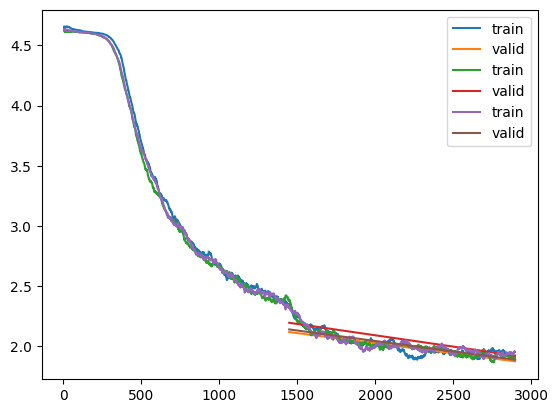

In [10]:
import gc
all_preds = []
for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(2, 4e-05, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='accuracy', patience=2)]) 
    torch.save(learn.model,f"celebmodel_{i}")
    
    learn.recorder.plot_loss()

    dls = ImageDataLoaders.from_df(test_df, 
                                   seed=seed,
                                   path = "./",
                                   folder = "../input/celebrity/test/test",
                                   fn_col='File Name', 
                                   label_col='target',
                                   y_block=CategoryBlock,
                                   bs=BATCH_SIZE,
                                   num_workers=8,
                                   item_tfms=Resize(224), 
                                   batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=3, beta=0)
    
    all_preds.append(preds)
    
    del learn, preds

    torch.cuda.empty_cache()

    gc.collect()

In [11]:
preds = np.mean(np.stack(all_preds), axis=0)
test_df['target'] = preds.argmax(dim=-1).numpy()
test_df["Category"] = le.inverse_transform(test_df["pred"])

TypeError: argmax() got an unexpected keyword argument 'dim'

In [ ]:
test_df.to_csv("submission.csv",index=False)